In [27]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.tree import plot_tree

data = pd.read_csv('csv/final_dataset_V2.csv')
print(data.columns)

# Separate features and response variables
X = data.iloc[:, 2:]                                # features
Y = data['temp_measured']                           # response variable: geothermal reservoir measured temperature
print(f'Features of dataset: {X.columns}')
print(f'Number of compenents in features: {X.shape[1]}')
print(Y.head(10))

Index(['well_sample', 'temp_measured', 'pH', 'Na', 'K', 'Ca', 'Mg', 'Cl',
       'SO4'],
      dtype='object')
Features of dataset: Index(['pH', 'Na', 'K', 'Ca', 'Mg', 'Cl', 'SO4'], dtype='object')
Number of compenents in features: 7
0    137.0
1    137.0
2    137.0
3    137.0
4    150.0
5    116.0
6    165.0
7    140.0
8    115.0
9    115.0
Name: temp_measured, dtype: float64


In [43]:
### Desicion tree with GridSearchCV for parameters tuning

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

start_time_dt_gs = time.time()

x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X, Y, test_size=0.15, random_state=50)

scaler = StandardScaler()
x_train_dt = scaler.fit_transform(x_train_dt)
x_test_dt = scaler.transform(x_test_dt)

# Setting up grid search cross validation for parameters tuning
# param_grid_dt: dictionary of parameters to be tested.
# cv: number of split for cross-validation: 5- fold cross-validation (validación cruzada quíntuple).
# scoring or evaluation metrics: mean squeared error. GridSearchCV maximize the scoring metrics, that's why it's called 'neg_mean_squared_error'.
# The actual calculation is: -1 * mean_squared_error

# Parameters tuning
tree_regressor = DecisionTreeRegressor()
param_grid_dt = {'criterion': ['squared_error'],
            'max_depth': [50, 75, 100],
            'min_samples_split': [5, 10, 25],
            'max_leaf_nodes': [25, 50, 75],
            'min_impurity_decrease': [0, 0.01, 0.1]}

grid_search_cv = GridSearchCV(
    estimator=tree_regressor, 
    param_grid=param_grid_dt, 
    cv=5, 
    verbose=1, 
    scoring='neg_mean_squared_error',
    n_jobs=-1                                         # n_jobs=-1 utilize all the cores avalaible,
    )


grid_search_cv.fit(x_train_dt, y_train_dt)
best_model_dt = grid_search_cv.best_estimator_

print('='*75)
print(f'Desicion tree regressor best parameters: \n{best_model_dt}')
print('='*75)

y_pred_test_dt = best_model_dt.predict(x_test_dt)
y_pred_train_dt = best_model_dt.predict(x_train_dt)

end_time_dt_gs = time.time()
training_time_dt_gs = end_time_dt_gs - start_time_dt_gs

def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_dt = r2_score(y_test_dt, y_pred_test_dt)
mse_dt = mean_squared_error(y_test_dt, y_pred_test_dt)
mslr_dt = mean_squared_log_error(y_test_dt, y_pred_test_dt)
mae_dt = mean_absolute_error(y_test_dt, y_pred_test_dt)
mrse_dt = mean_relative_squared_error(y_test_dt, y_pred_test_dt)

eval_metrics_dt = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'Desicion_tree_GS': [r2_dt, mse_dt, mae_dt, mslr_dt, mrse_dt, training_time_dt_gs]
}

df_metrics_dt = pd.DataFrame(eval_metrics_dt)
df_metrics_dt.to_csv('metrics/metrics_dt_gs.csv', index=False)

print(tabulate(df_metrics_dt.round(4), headers='keys', tablefmt='pretty', showindex=False))

#joblib.dump(tree_regressor, 'dt_model.joblib')
#print("Decision Tree model saved as 'decision_tree_model.joblib'.")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Desicion tree regressor best parameters: 
DecisionTreeRegressor(max_depth=50, max_leaf_nodes=25, min_impurity_decrease=0,
                      min_samples_split=25)
+---------------+------------------+
| Eval_metrics  | Desicion_tree_GS |
+---------------+------------------+
|   R2 Score    |      0.7336      |
|      MSE      |    1168.7509     |
|      MAE      |     23.2762      |
|     MSLE      |      0.0609      |
|     MRSE      |      0.0884      |
| Training time |      0.2138      |
+---------------+------------------+


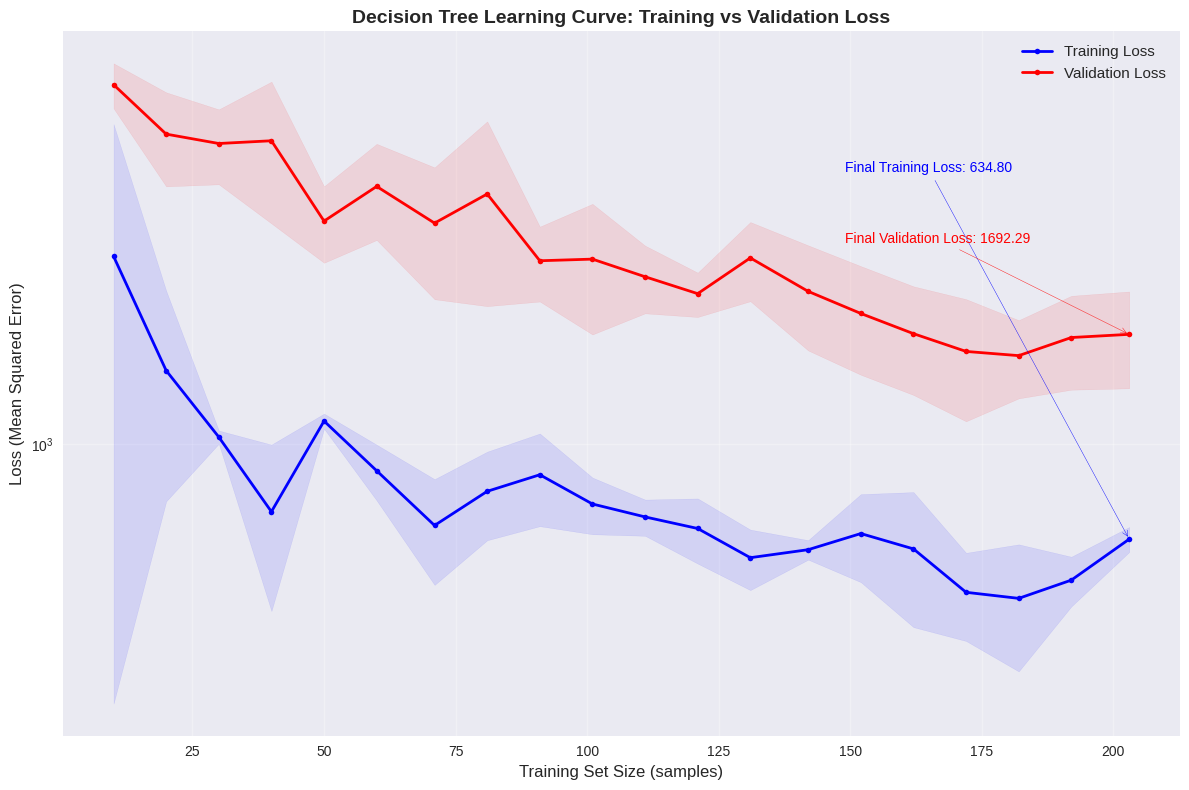

Learning Curve Analysis:
Training samples range: 10 to 203
Training loss improvement: 2459.31 → 634.80
Validation loss trend: 5593.65 → 1692.29
✅ Good generalization observed


In [61]:
# Detailed Learning Curve Analysis
from sklearn.model_selection import learning_curve

plt.figure(figsize=(12, 8))

# More granular training sizes
train_sizes = np.linspace(0.05, 1.0, 20)
train_sizes_abs, train_scores, val_scores = learning_curve(
    best_model_dt,
    x_train_dt, y_train_dt,
    train_sizes=train_sizes,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Calculate statistics
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

# Plot with error bands
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='blue', 
         label='Training Loss', linewidth=2, markersize=4)
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')

plt.plot(train_sizes_abs, val_scores_mean, 'o-', color='red', 
         label='Validation Loss', linewidth=2, markersize=4)
plt.fill_between(train_sizes_abs, val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std, alpha=0.1, color='red')

plt.xlabel('Training Set Size (samples)', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.title('Decision Tree Learning Curve: Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Add annotations
plt.annotate(f'Final Training Loss: {train_scores_mean[-1]:.2f}', 
            xy=(train_sizes_abs[-1], train_scores_mean[-1]), 
            xytext=(0.7, 0.8), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='blue'),
            fontsize=10, color='blue')

plt.annotate(f'Final Validation Loss: {val_scores_mean[-1]:.2f}', 
            xy=(train_sizes_abs[-1], val_scores_mean[-1]), 
            xytext=(0.7, 0.7), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Print learning curve insights
print("Learning Curve Analysis:")
print(f"Training samples range: {train_sizes_abs[0]:.0f} to {train_sizes_abs[-1]:.0f}")
print(f"Training loss improvement: {train_scores_mean[0]:.2f} → {train_scores_mean[-1]:.2f}")
print(f"Validation loss trend: {val_scores_mean[0]:.2f} → {val_scores_mean[-1]:.2f}")
if val_scores_mean[-1] > val_scores_mean[-5]:
    print("⚠️  Potential overfitting detected in recent samples")
else:
    print("✅ Good generalization observed")

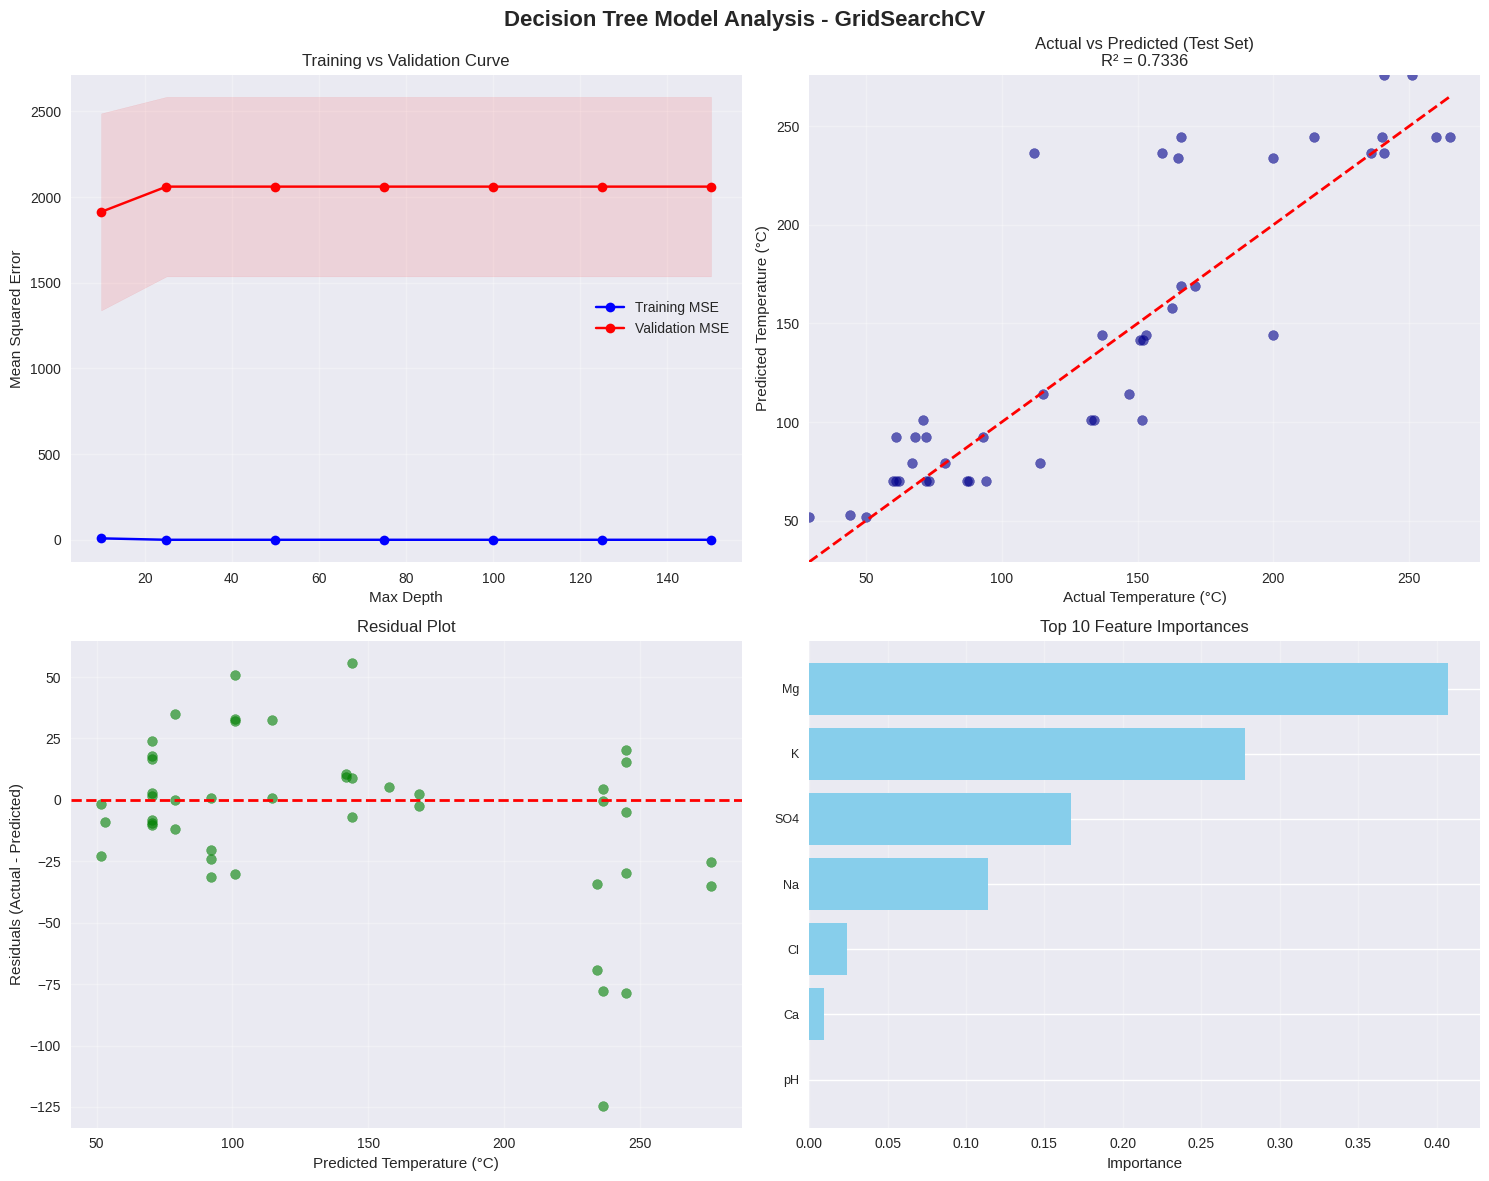


Model Performance Summary:
Best CV Score (MSE): 1776.2777
Test R²: 0.7336
Mean Absolute Error: 23.28°C
Root Mean Squared Error: 34.19°C


In [44]:


# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Decision Tree Model Analysis - GridSearchCV', fontsize=16, fontweight='bold')

# 1. Training vs Validation Curve
max_depths = [10, 25, 50, 75, 100, 125, 150]
train_scores, val_scores = validation_curve(
    DecisionTreeRegressor(random_state=42), 
    x_train_dt, y_train_dt,
    param_name='max_depth', 
    param_range=max_depths,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

axes[0, 0].plot(max_depths, train_scores_mean, 'o-', color='blue', label='Training MSE')
axes[0, 0].fill_between(max_depths, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axes[0, 0].plot(max_depths, val_scores_mean, 'o-', color='red', label='Validation MSE')
axes[0, 0].fill_between(max_depths, val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std, alpha=0.1, color='red')
axes[0, 0].set_xlabel('Max Depth')
axes[0, 0].set_ylabel('Mean Squared Error')
axes[0, 0].set_title('Training vs Validation Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test Set)
axes[0, 1].scatter(y_test_dt, y_pred_test_dt, alpha=0.6, color='darkblue', s=50)
axes[0, 1].plot([y_test_dt.min(), y_test_dt.max()], [y_test_dt.min(), y_test_dt.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Temperature (°C)')
axes[0, 1].set_ylabel('Predicted Temperature (°C)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {r2_dt:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Add equal axes for better visualization
min_val = min(y_test_dt.min(), y_pred_test_dt.min())
max_val = max(y_test_dt.max(), y_pred_test_dt.max())
axes[0, 1].set_xlim(min_val, max_val)
axes[0, 1].set_ylim(min_val, max_val)

# 3. Residual Plot
residuals = y_test_dt - y_pred_test_dt
axes[1, 0].scatter(y_pred_test_dt, residuals, alpha=0.6, color='green', s=50)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance
feature_importance = best_model_dt.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Top 10 most important features
top_features = importance_df.tail(10)
axes[1, 1].barh(range(len(top_features)), top_features['importance'], color='skyblue')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importances')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"Best CV Score (MSE): {-grid_search_cv.best_score_:.4f}")
print(f"Test R²: {r2_dt:.4f}")
print(f"Mean Absolute Error: {mae_dt:.2f}°C")
print(f"Root Mean Squared Error: {np.sqrt(mse_dt):.2f}°C")

In [46]:
### Decision tree with RandomizedSearchCV for parameters tuning

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

start_time_dt_rs = time.time()

x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X, Y, test_size=0.15, random_state=50)

scaler = StandardScaler()
x_train_dt = scaler.fit_transform(x_train_dt)
x_test_dt = scaler.transform(x_test_dt)

# Parameters tuning with distributions for RandomizedSearchCV
tree_regressor = DecisionTreeRegressor()
param_distributions_dt = {
    'criterion': ['squared_error'],
    'max_depth': randint(50, 100),             
    'min_samples_split': randint(5, 25),        
    'max_leaf_nodes': randint(25, 75),          
    'min_impurity_decrease': uniform(0, 0.1)    
}

random_search_cv = RandomizedSearchCV(
    estimator=tree_regressor, 
    param_distributions=param_distributions_dt, 
    n_iter=50,  # Number of parameter settings sampled
    cv=5, 
    verbose=1, 
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search_cv.fit(x_train_dt, y_train_dt)
best_model_dt = random_search_cv.best_estimator_
print('='*75)
print(f'Decision tree regressor best parameters: \n{best_model_dt}')
print('='*75)
y_pred_test_dt = best_model_dt.predict(x_test_dt)
y_pred_train_dt = best_model_dt.predict(x_train_dt)

end_time_dt_rs = time.time()
training_time_dt_rs = end_time_dt_rs - start_time_dt_rs

def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_dt = r2_score(y_test_dt, y_pred_test_dt)
mse_dt = mean_squared_error(y_test_dt, y_pred_test_dt)
mslr_dt = mean_squared_log_error(y_test_dt, y_pred_test_dt)
mae_dt = mean_absolute_error(y_test_dt, y_pred_test_dt)
mrse_dt = mean_relative_squared_error(y_test_dt, y_pred_test_dt)

eval_metrics_dt = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'Decision_tree_RS': [r2_dt, mse_dt, mae_dt, mslr_dt, mrse_dt, training_time_dt_rs]
}

df_metrics_dt = pd.DataFrame(eval_metrics_dt)
df_metrics_dt.to_csv('metrics/metrics_dt_rs.csv', index=False)

print(tabulate(df_metrics_dt.round(4), headers='keys', tablefmt='pretty', showindex=False))

#joblib.dump(best_model_dt, 'dt_randomized_model.joblib')
#print("Decision Tree model saved as 'dt_randomized_model.joblib'.")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Decision tree regressor best parameters: 
DecisionTreeRegressor(max_depth=70, max_leaf_nodes=57,
                      min_impurity_decrease=0.030424224295953775,
                      min_samples_split=16)
+---------------+------------------+
| Eval_metrics  | Decision_tree_RS |
+---------------+------------------+
|   R2 Score    |      0.8025      |
|      MSE      |     866.3252     |
|      MAE      |     20.5784      |
|     MSLE      |      0.0501      |
|     MRSE      |      0.062       |
| Training time |      0.1717      |
+---------------+------------------+


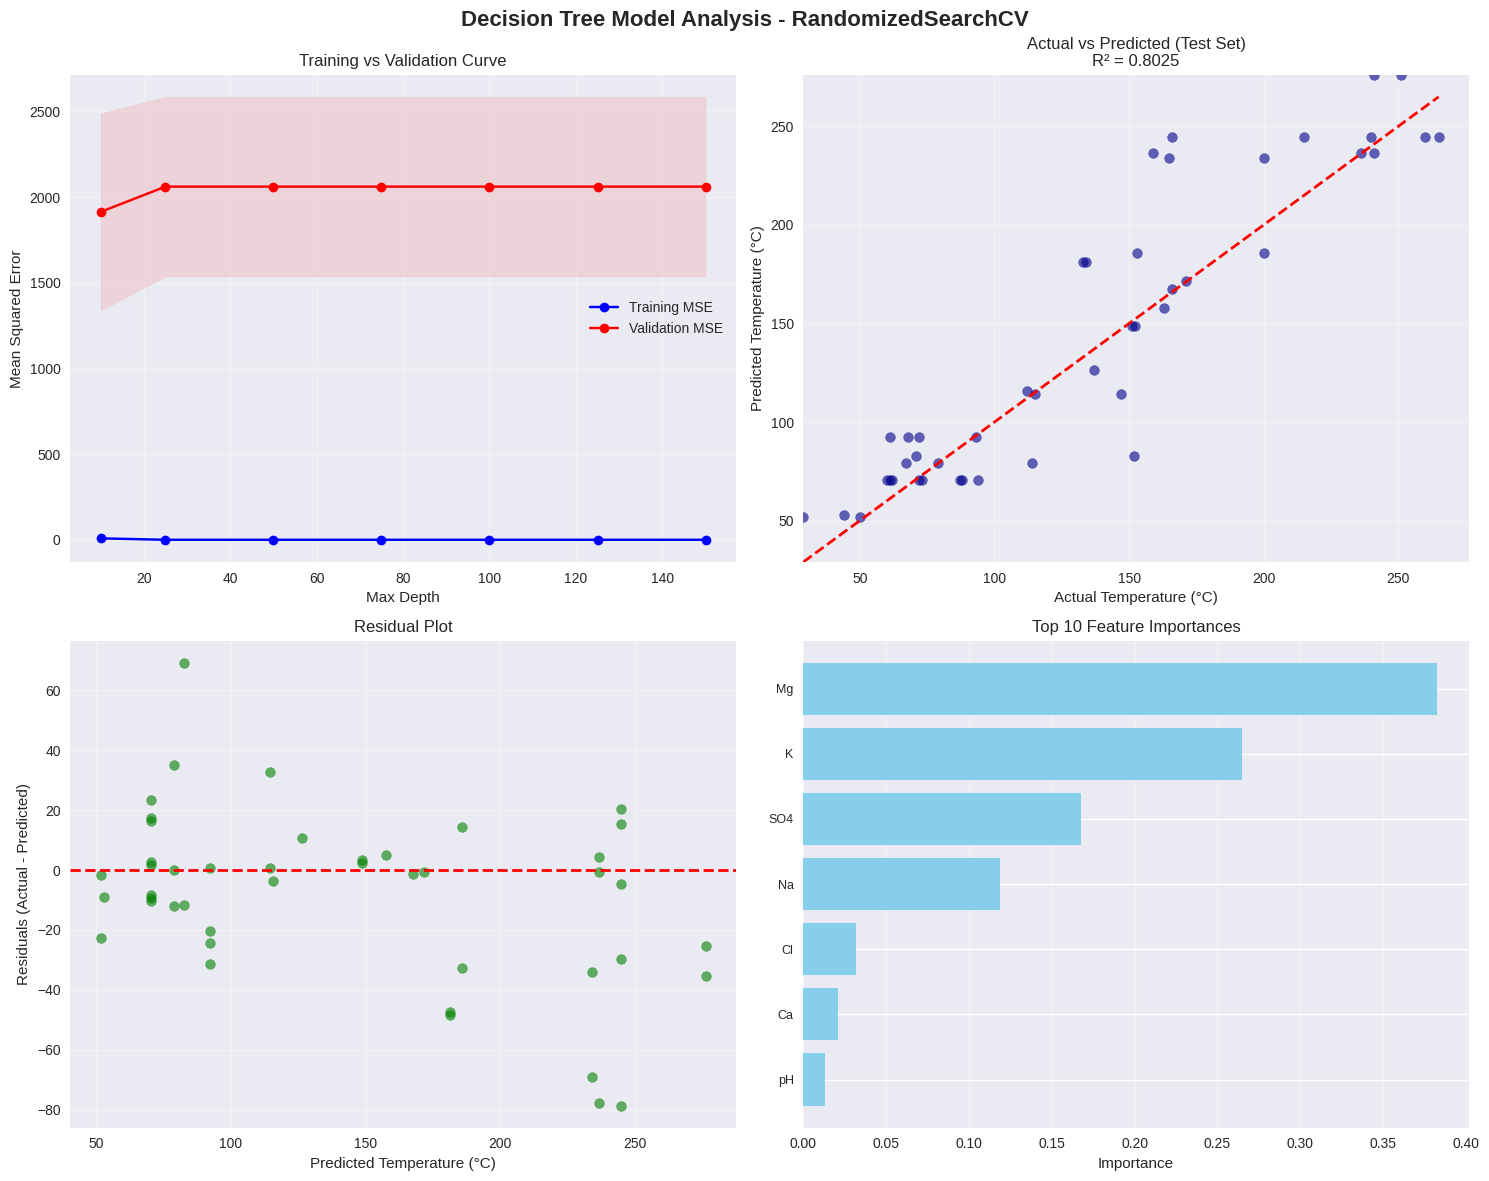


Model Performance Summary:
Best CV Score (MSE): 1683.6366
Test R²: 0.8025
Mean Absolute Error: 20.58°C
Root Mean Squared Error: 29.43°C


In [47]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Decision Tree Model Analysis - RandomizedSearchCV', fontsize=16, fontweight='bold')

# 1. Training vs Validation Curve
max_depths = [10, 25, 50, 75, 100, 125, 150]
train_scores, val_scores = validation_curve(
    DecisionTreeRegressor(random_state=42), 
    x_train_dt, y_train_dt,
    param_name='max_depth', 
    param_range=max_depths,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

axes[0, 0].plot(max_depths, train_scores_mean, 'o-', color='blue', label='Training MSE')
axes[0, 0].fill_between(max_depths, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axes[0, 0].plot(max_depths, val_scores_mean, 'o-', color='red', label='Validation MSE')
axes[0, 0].fill_between(max_depths, val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std, alpha=0.1, color='red')
axes[0, 0].set_xlabel('Max Depth')
axes[0, 0].set_ylabel('Mean Squared Error')
axes[0, 0].set_title('Training vs Validation Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test Set)
axes[0, 1].scatter(y_test_dt, y_pred_test_dt, alpha=0.6, color='darkblue', s=50)
axes[0, 1].plot([y_test_dt.min(), y_test_dt.max()], [y_test_dt.min(), y_test_dt.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Temperature (°C)')
axes[0, 1].set_ylabel('Predicted Temperature (°C)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {r2_dt:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Add equal axes for better visualization
min_val = min(y_test_dt.min(), y_pred_test_dt.min())
max_val = max(y_test_dt.max(), y_pred_test_dt.max())
axes[0, 1].set_xlim(min_val, max_val)
axes[0, 1].set_ylim(min_val, max_val)

# 3. Residual Plot
residuals = y_test_dt - y_pred_test_dt
axes[1, 0].scatter(y_pred_test_dt, residuals, alpha=0.6, color='green', s=50)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance
feature_importance = best_model_dt.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Top 10 most important features
top_features = importance_df.tail(10)
axes[1, 1].barh(range(len(top_features)), top_features['importance'], color='skyblue')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importances')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"Best CV Score (MSE): {-random_search_cv.best_score_:.4f}")
print(f"Test R²: {r2_dt:.4f}")
print(f"Mean Absolute Error: {mae_dt:.2f}°C")
print(f"Root Mean Squared Error: {np.sqrt(mse_dt):.2f}°C")

In [51]:
### Decision Tree with Optuna hyperparameter optimization

import optuna
from sklearn.model_selection import cross_val_score

start_time_dt_op = time.time()

x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(X, Y, test_size=0.15, random_state=50)

scaler = StandardScaler()
x_train_dt = scaler.fit_transform(x_train_dt)
x_test_dt = scaler.transform(x_test_dt)

def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 50, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 25),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 25, 75),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.1)
    }
    model = DecisionTreeRegressor(**params, random_state=42)
    score = cross_val_score(model, x_train_dt, y_train_dt, cv=5, scoring='neg_mean_squared_error').mean()
    return -score

optuna_dt = optuna.create_study(direction='minimize')
optuna_dt.optimize(objective_dt, n_trials=40, show_progress_bar=False)

print('='*125)
print(f"Best Decision Tree params: \n{optuna_dt.best_params}")
print('='*125)

best_dt = DecisionTreeRegressor(**optuna_dt.best_params, random_state=42)
best_dt.fit(x_train_dt, y_train_dt)
y_pred_dt = best_dt.predict(x_test_dt)

final_time_dt_op = time.time()
training_time_dt_op = final_time_dt_op - start_time_dt_op

def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_dt = r2_score(y_test_dt, y_pred_dt)
mse_dt = mean_squared_error(y_test_dt, y_pred_dt)
mae_dt = mean_absolute_error(y_test_dt, y_pred_dt)
msle_dt = mean_squared_log_error(y_test_dt, y_pred_dt)
mrse_dt = mean_relative_squared_error(y_test_dt, y_pred_dt)

dt_eval_metrics = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'Decision_tree_Op': [r2_dt, mse_dt, mae_dt, msle_dt, mrse_dt, training_time_dt_op]
}

dt_df_metrics = pd.DataFrame(dt_eval_metrics)
dt_df_metrics.to_csv('metrics/metrics_dt_op.csv', index=False)

print(tabulate(dt_df_metrics.round(4), headers='keys', tablefmt='pretty', showindex=False))

[I 2025-09-04 18:24:53,488] A new study created in memory with name: no-name-baab1ef8-a9ba-4f65-ba7c-4716ac5b9587
[I 2025-09-04 18:24:53,503] Trial 0 finished with value: 1968.3507419220919 and parameters: {'max_depth': 93, 'min_samples_split': 7, 'max_leaf_nodes': 55, 'min_impurity_decrease': 0.0958528242538707}. Best is trial 0 with value: 1968.3507419220919.
[I 2025-09-04 18:24:53,519] Trial 1 finished with value: 1895.1194449980653 and parameters: {'max_depth': 97, 'min_samples_split': 8, 'max_leaf_nodes': 31, 'min_impurity_decrease': 0.06566303643347855}. Best is trial 1 with value: 1895.1194449980653.
[I 2025-09-04 18:24:53,531] Trial 2 finished with value: 1711.146362660831 and parameters: {'max_depth': 89, 'min_samples_split': 17, 'max_leaf_nodes': 26, 'min_impurity_decrease': 0.08120953759685505}. Best is trial 2 with value: 1711.146362660831.
[I 2025-09-04 18:24:53,543] Trial 3 finished with value: 1768.5193452357075 and parameters: {'max_depth': 81, 'min_samples_split': 13, 

Best Decision Tree params: 
{'max_depth': 94, 'min_samples_split': 16, 'max_leaf_nodes': 25, 'min_impurity_decrease': 0.022654289068565283}
+---------------+------------------+
| Eval_metrics  | Decision_tree_Op |
+---------------+------------------+
|   R2 Score    |      0.6649      |
|      MSE      |    1470.1043     |
|      MAE      |     24.5274      |
|     MSLE      |      0.0682      |
|     MRSE      |      0.1099      |
| Training time |      1.0523      |
+---------------+------------------+


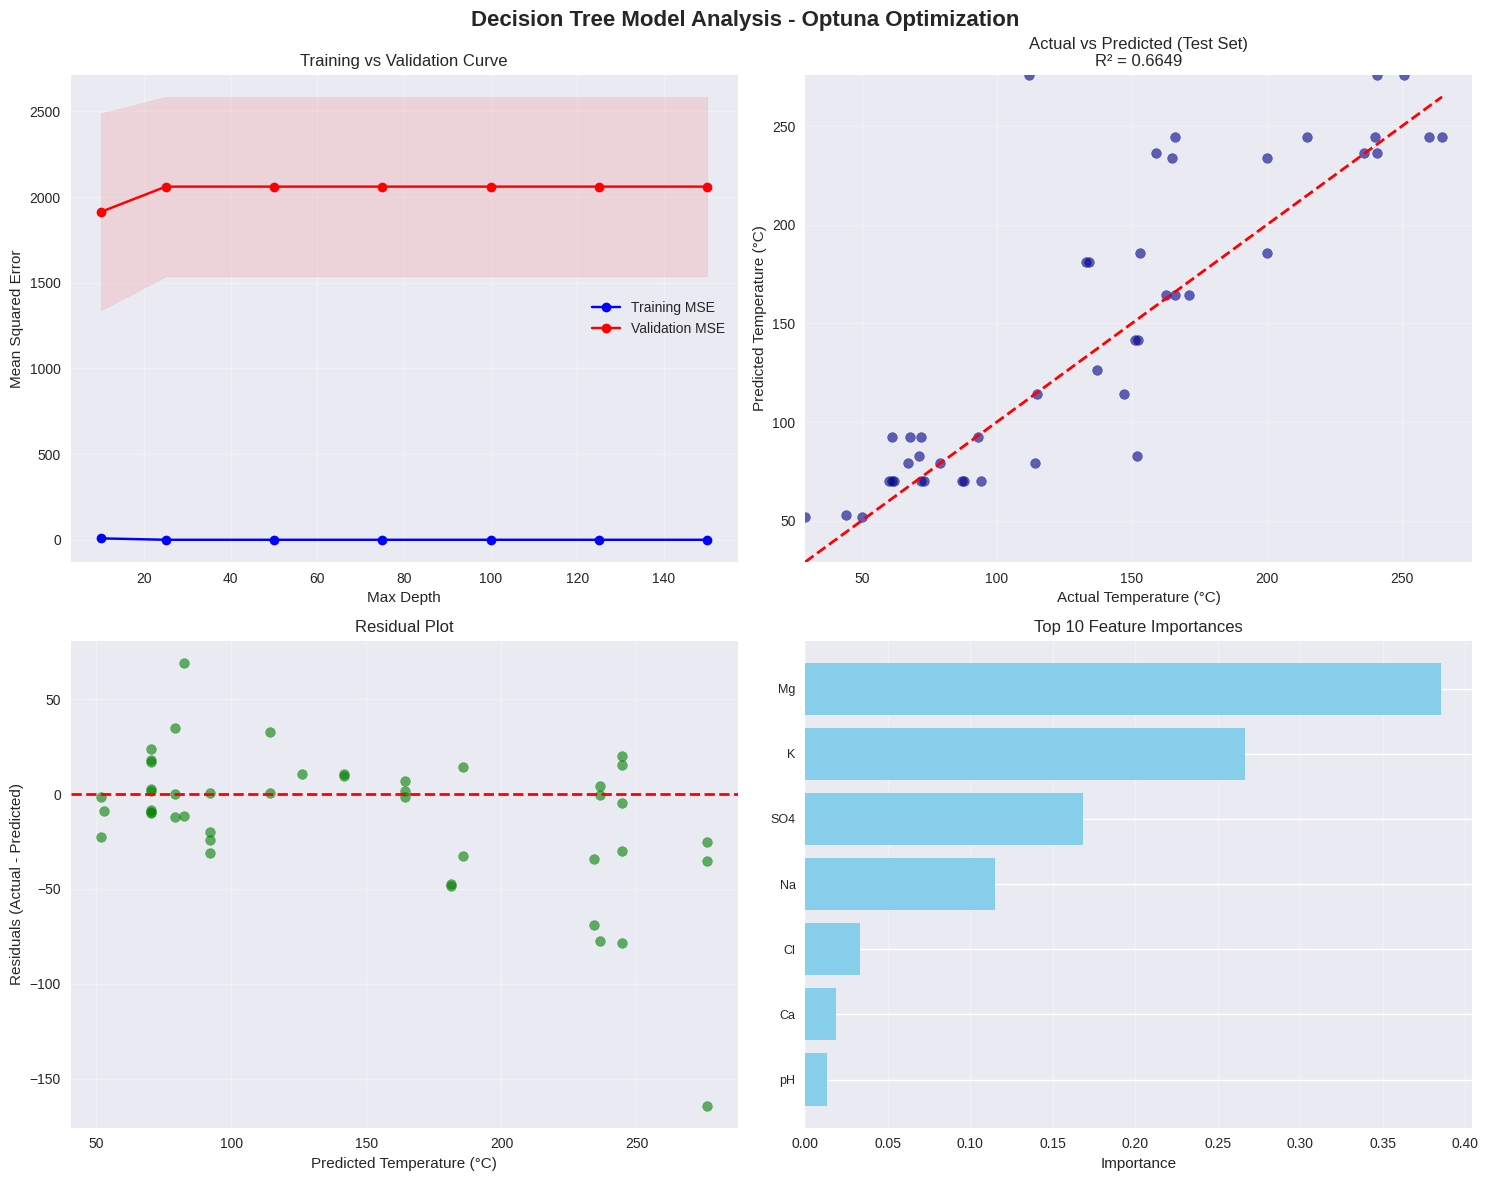


Model Performance Summary:
Best Optuna Score (MSE): 1683.6347
Test R²: 0.6649
Mean Absolute Error: 24.53°C
Root Mean Squared Error: 38.34°C


In [52]:

import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Decision Tree Model Analysis - Optuna Optimization', fontsize=16, fontweight='bold')

# 1. Training vs Validation Curve
max_depths = [10, 25, 50, 75, 100, 125, 150]
train_scores, val_scores = validation_curve(
    DecisionTreeRegressor(random_state=42), 
    x_train_dt, y_train_dt,
    param_name='max_depth', 
    param_range=max_depths,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

axes[0, 0].plot(max_depths, train_scores_mean, 'o-', color='blue', label='Training MSE')
axes[0, 0].fill_between(max_depths, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axes[0, 0].plot(max_depths, val_scores_mean, 'o-', color='red', label='Validation MSE')
axes[0, 0].fill_between(max_depths, val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std, alpha=0.1, color='red')
axes[0, 0].set_xlabel('Max Depth')
axes[0, 0].set_ylabel('Mean Squared Error')
axes[0, 0].set_title('Training vs Validation Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test Set)
axes[0, 1].scatter(y_test_dt, y_pred_dt, alpha=0.6, color='darkblue', s=50)
axes[0, 1].plot([y_test_dt.min(), y_test_dt.max()], [y_test_dt.min(), y_test_dt.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Temperature (°C)')
axes[0, 1].set_ylabel('Predicted Temperature (°C)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {r2_dt:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Add equal axes for better visualization
min_val = min(y_test_dt.min(), y_pred_dt.min())
max_val = max(y_test_dt.max(), y_pred_dt.max())
axes[0, 1].set_xlim(min_val, max_val)
axes[0, 1].set_ylim(min_val, max_val)

# 3. Residual Plot
residuals = y_test_dt - y_pred_dt
axes[1, 0].scatter(y_pred_dt, residuals, alpha=0.6, color='green', s=50)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance
feature_importance = best_dt.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Top 10 most important features
top_features = importance_df.tail(10)
axes[1, 1].barh(range(len(top_features)), top_features['importance'], color='skyblue')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importances')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"Best Optuna Score (MSE): {optuna_dt.best_value:.4f}")
print(f"Test R²: {r2_dt:.4f}")
print(f"Mean Absolute Error: {mae_dt:.2f}°C")
print(f"Root Mean Squared Error: {np.sqrt(mse_dt):.2f}°C")

In [53]:
### Random Forest with RandomizedSearchCV for hyperparameter optimization

from sklearn.ensemble import RandomForestRegressor
import time

start_time_rf_rs = time.time()

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X, Y, test_size=0.15, random_state=50)

scaler = StandardScaler()
x_train_rf = scaler.fit_transform(x_train_rf)
x_test_rf = scaler.transform(x_test_rf)

# Define parameter distributions for RandomizedSearchCV
rf_param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# RandomizedSearchCV with Random Forest
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search_rf = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=rf_param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,
    verbose=1,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(x_train_rf, y_train_rf)
best_rf = random_search_rf.best_estimator_

print("="*135)
print(f"Best Random Forest params: \n{random_search_rf.best_params_}")
print("="*135)
y_pred_rf = best_rf.predict(x_test_rf)

end_time_rf_rs = time.time()
training_time_rf_rs= end_time_rf_rs - start_time_rf_rs

def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_rf = r2_score(y_test_rf, y_pred_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
msle_rf = mean_squared_log_error(y_test_rf, y_pred_rf)
mrse_rf = mean_relative_squared_error(y_test_rf, y_pred_rf)

rf_eval_metrics = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'Random_forest_RS': [r2_rf, mse_rf, mae_rf, msle_rf, mrse_rf, training_time_rf_rs]
}

rf_df_metrics = pd.DataFrame(rf_eval_metrics)
rf_df_metrics.to_csv('metrics/metrics_rf_rs.csv', index=False)

print(tabulate(rf_df_metrics.round(4), headers='keys', tablefmt='pretty', showindex=False))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest params: 
{'bootstrap': False, 'max_depth': 34, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 363}
+---------------+------------------+
| Eval_metrics  | Random_forest_RS |
+---------------+------------------+
|   R2 Score    |      0.8885      |
|      MSE      |     489.0396     |
|      MAE      |     13.3476      |
|     MSLE      |      0.0722      |
|     MRSE      |      0.2648      |
| Training time |     12.3141      |
+---------------+------------------+


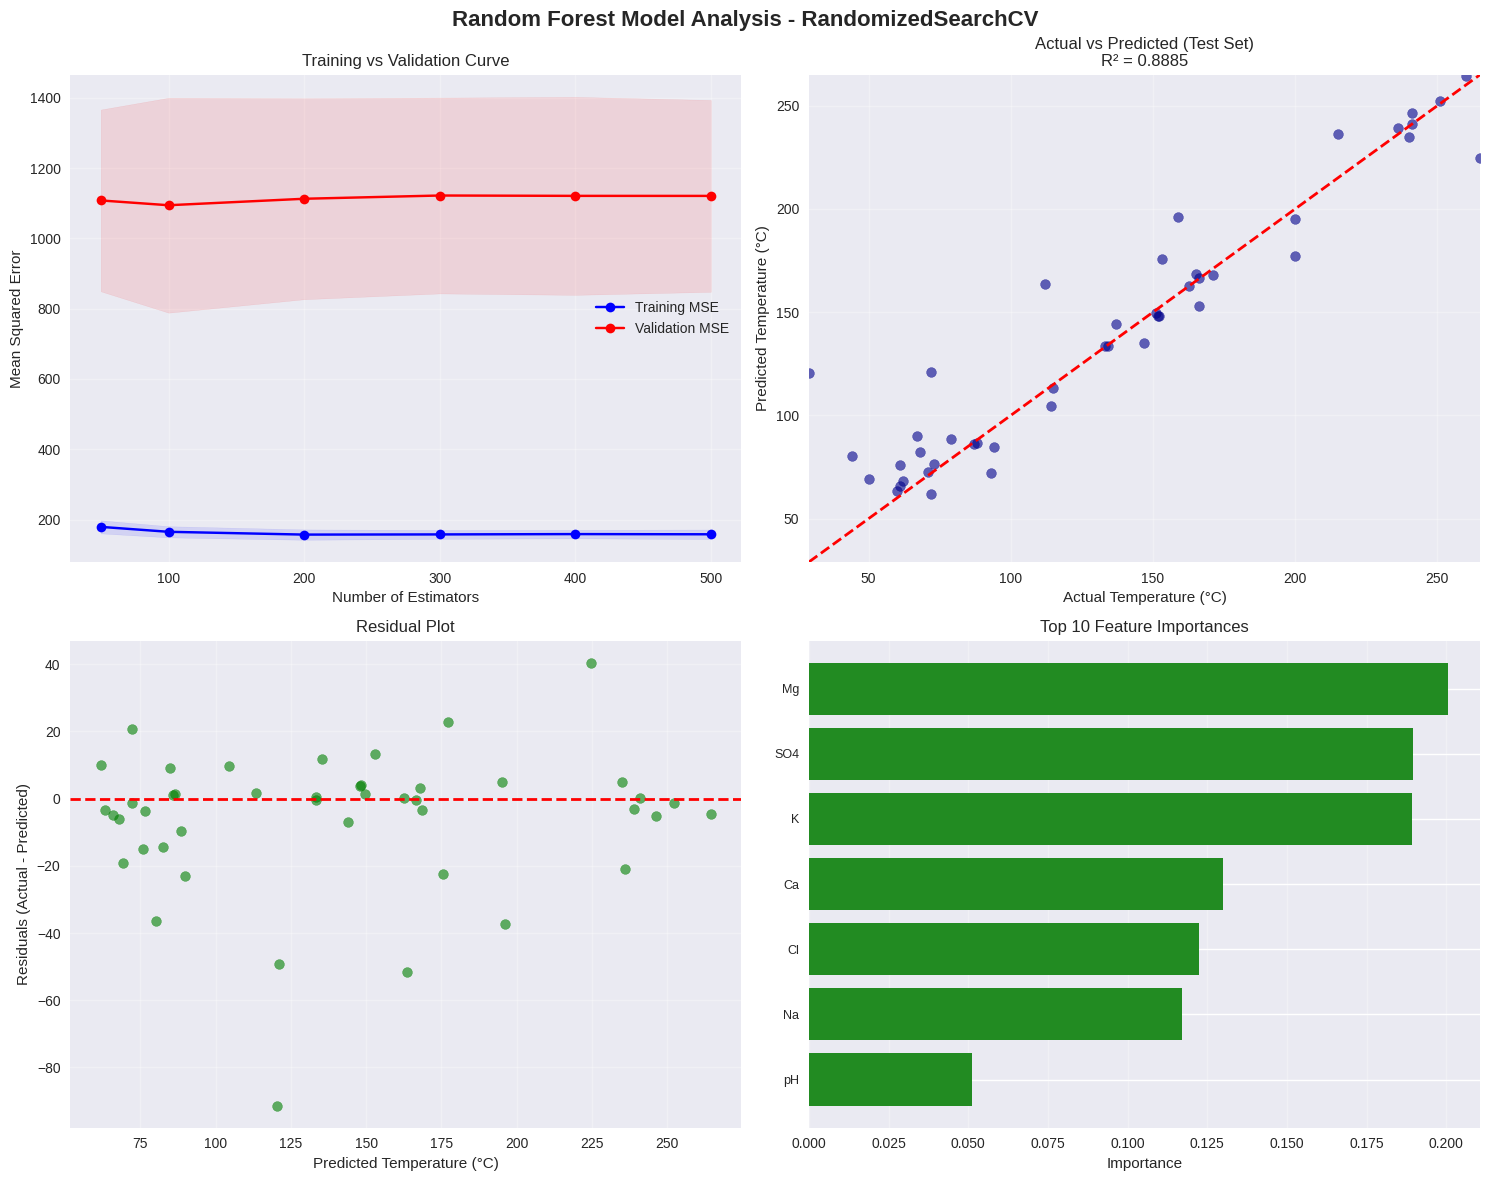


Model Performance Summary:
Best CV Score (MSE): 1095.6446
Test R²: 0.8885
Mean Absolute Error: 13.35°C
Root Mean Squared Error: 22.11°C


In [54]:


# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Model Analysis - RandomizedSearchCV', fontsize=16, fontweight='bold')

# 1. Training vs Validation Curve (using n_estimators as parameter)
n_estimators_range = [50, 100, 200, 300, 400, 500]
train_scores, val_scores = validation_curve(
    RandomForestRegressor(random_state=42, n_jobs=-1), 
    x_train_rf, y_train_rf,
    param_name='n_estimators', 
    param_range=n_estimators_range,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

axes[0, 0].plot(n_estimators_range, train_scores_mean, 'o-', color='blue', label='Training MSE')
axes[0, 0].fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axes[0, 0].plot(n_estimators_range, val_scores_mean, 'o-', color='red', label='Validation MSE')
axes[0, 0].fill_between(n_estimators_range, val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std, alpha=0.1, color='red')
axes[0, 0].set_xlabel('Number of Estimators')
axes[0, 0].set_ylabel('Mean Squared Error')
axes[0, 0].set_title('Training vs Validation Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test Set)
axes[0, 1].scatter(y_test_rf, y_pred_rf, alpha=0.6, color='darkblue', s=50)
axes[0, 1].plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Temperature (°C)')
axes[0, 1].set_ylabel('Predicted Temperature (°C)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {r2_rf:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Add equal axes for better visualization
min_val = min(y_test_rf.min(), y_pred_rf.min())
max_val = max(y_test_rf.max(), y_pred_rf.max())
axes[0, 1].set_xlim(min_val, max_val)
axes[0, 1].set_ylim(min_val, max_val)

# 3. Residual Plot
residuals = y_test_rf - y_pred_rf
axes[1, 0].scatter(y_pred_rf, residuals, alpha=0.6, color='green', s=50)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance
feature_importance = best_rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Top 10 most important features
top_features = importance_df.tail(10)
axes[1, 1].barh(range(len(top_features)), top_features['importance'], color='forestgreen')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importances')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"Best CV Score (MSE): {-random_search_rf.best_score_:.4f}")
print(f"Test R²: {r2_rf:.4f}")
print(f"Mean Absolute Error: {mae_rf:.2f}°C")
print(f"Root Mean Squared Error: {np.sqrt(mse_rf):.2f}°C")

In [55]:
### Random Forest with Optuna hyperparameter optimization

start_time_rf_op = time.time()

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X, Y, test_size=0.15, random_state=50)

scaler = StandardScaler()
x_train_rf = scaler.fit_transform(x_train_rf)
x_test_rf = scaler.transform(x_test_rf)

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(model, x_train_rf, y_train_rf, cv=5, scoring='neg_mean_squared_error').mean()
    return -score

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=40)

print("Best Random Forest params:", study_rf.best_params)

best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf.fit(x_train_rf, y_train_rf)
y_pred_rf = best_rf.predict(x_test_rf)

end_time_rf_op = time.time()
training_time_rf_op = end_time_rf_op - start_time_rf_op

def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_rf = r2_score(y_test_rf, y_pred_rf)
mse_rf = mean_squared_error(y_test_rf, y_pred_rf)
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
msle_rf = mean_squared_log_error(y_test_rf, y_pred_rf)
mrse_rf = mean_relative_squared_error(y_test_rf, y_pred_rf)

rf_eval_metrics = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'Random_forest_Op': [r2_rf, mse_rf, mae_rf, msle_rf, mrse_rf, training_time_rf_op]
}

rf_df_metrics = pd.DataFrame(rf_eval_metrics)
rf_df_metrics.to_csv('metrics/metrics_rf_op.csv', index=False)

print(tabulate(rf_df_metrics.round(4), headers='keys', tablefmt='pretty', showindex=False))

[I 2025-09-04 18:27:35,412] A new study created in memory with name: no-name-5b0c31cb-68da-4c91-b254-4629f407e534
[I 2025-09-04 18:27:36,753] Trial 0 finished with value: 1437.3216793953914 and parameters: {'n_estimators': 227, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 1437.3216793953914.
[I 2025-09-04 18:27:38,345] Trial 1 finished with value: 1290.2444747919328 and parameters: {'n_estimators': 413, 'max_depth': 41, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 1290.2444747919328.
[I 2025-09-04 18:27:39,399] Trial 2 finished with value: 1157.7675095366058 and parameters: {'n_estimators': 179, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 1157.7675095366058.
[I 2025-09-04 18:27:39,879] Trial 3 finished with value: 1755.7608544911775 an

Best Random Forest params: {'n_estimators': 319, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}
+---------------+------------------+
| Eval_metrics  | Random_forest_Op |
+---------------+------------------+
|   R2 Score    |      0.8891      |
|      MSE      |     486.6529     |
|      MAE      |     13.4429      |
|     MSLE      |      0.074       |
|     MRSE      |      0.2863      |
| Training time |     53.7262      |
+---------------+------------------+


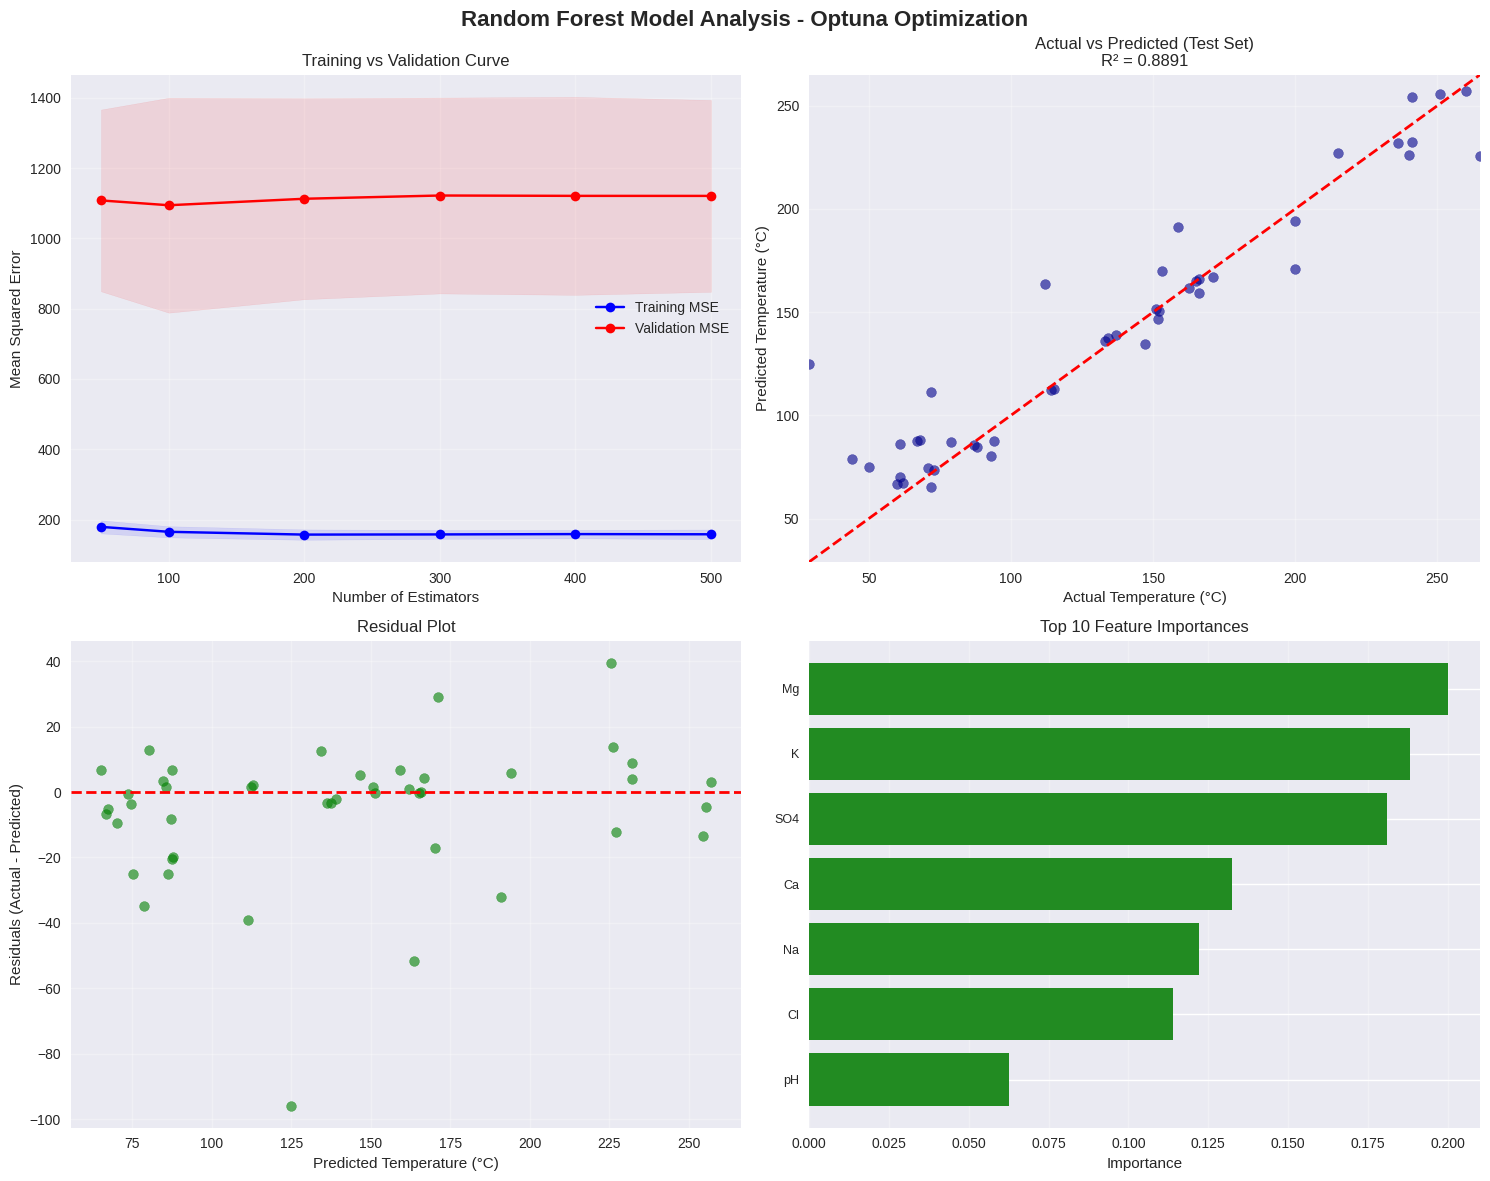


Model Performance Summary:
Best Optuna Score (MSE): 1087.0262
Test R²: 0.8891
Mean Absolute Error: 13.44°C
Root Mean Squared Error: 22.06°C


In [56]:
# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Random Forest Model Analysis - Optuna Optimization', fontsize=16, fontweight='bold')

# 1. Training vs Validation Curve (using n_estimators as parameter)
n_estimators_range = [50, 100, 200, 300, 400, 500]
train_scores, val_scores = validation_curve(
    RandomForestRegressor(random_state=42, n_jobs=-1), 
    x_train_rf, y_train_rf,
    param_name='n_estimators', 
    param_range=n_estimators_range,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

axes[0, 0].plot(n_estimators_range, train_scores_mean, 'o-', color='blue', label='Training MSE')
axes[0, 0].fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axes[0, 0].plot(n_estimators_range, val_scores_mean, 'o-', color='red', label='Validation MSE')
axes[0, 0].fill_between(n_estimators_range, val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std, alpha=0.1, color='red')
axes[0, 0].set_xlabel('Number of Estimators')
axes[0, 0].set_ylabel('Mean Squared Error')
axes[0, 0].set_title('Training vs Validation Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test Set)
axes[0, 1].scatter(y_test_rf, y_pred_rf, alpha=0.6, color='darkblue', s=50)
axes[0, 1].plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Temperature (°C)')
axes[0, 1].set_ylabel('Predicted Temperature (°C)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {r2_rf:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Add equal axes for better visualization
min_val = min(y_test_rf.min(), y_pred_rf.min())
max_val = max(y_test_rf.max(), y_pred_rf.max())
axes[0, 1].set_xlim(min_val, max_val)
axes[0, 1].set_ylim(min_val, max_val)

# 3. Residual Plot
residuals = y_test_rf - y_pred_rf
axes[1, 0].scatter(y_pred_rf, residuals, alpha=0.6, color='green', s=50)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance
feature_importance = best_rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Top 10 most important features
top_features = importance_df.tail(10)
axes[1, 1].barh(range(len(top_features)), top_features['importance'], color='forestgreen')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importances')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"Best Optuna Score (MSE): {study_rf.best_value:.4f}")
print(f"Test R²: {r2_rf:.4f}")
print(f"Mean Absolute Error: {mae_rf:.2f}°C")
print(f"Root Mean Squared Error: {np.sqrt(mse_rf):.2f}°C")

In [58]:
### XGBoost implementation with RandomizedSearchCV for faster hyperparametr tuning
'''
Unlike GridSearchCV, which tries all possible combiationn of hyperparameters,
RandomizedSearchCV samples a fixed number of hyperparameters combinations from
the specified space. This is useful when you have a large hyprparameteres space,
as it saves time by exploring only a subset of all possible combinations.
'''

import xgboost as xgb

start_time_xg_rs = time.time()

x_train_xg, x_test_xg, y_train_log_xg, y_test_log_xg = train_test_split(X, np.log(Y), test_size = 0.15, random_state = 50)

scaler = StandardScaler()
x_train_xg = scaler.fit_transform(x_train_xg)
x_test_xg = scaler.transform(x_test_xg)

xgb_regressor = xgb.XGBRegressor() # (tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False)   # Use GPU for training

# Convert data into DMatrix (XGBoost optimized data structure)
dtrain = xgb.DMatrix(x_train_xg, label=y_train_log_xg)
dtest = xgb.DMatrix(x_test_xg, label=y_test_log_xg)

# Define the space of hyperparameters
xgb_param_distributions = {
    'colsample_bytree': uniform(0.1, 0.9),
    'learning_rate': uniform(0.00001, 0.99999),
    'max_depth': randint(1, 100),
    'n_estimators': randint(5, 10000),
    'subsample': uniform(0.1, 0.9),
    'reg_alpha': uniform(1e-8, 0.99),
    'reg_lambda': uniform(1e-8, 0.99)
}



# Define scoring functions
scorers = {
    'r2': make_scorer(r2_score),
    'neg_mse': make_scorer(mean_squared_error, greater_is_better=False)
}

# RandomizedSearchCV with cross-validation to optimize hyperparameter tuning
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=xgb_param_distributions,
    scoring=scorers,
    refit='r2',         # Refit the model using R2 after searching
    cv=5,              # 10-fold cross-validation
    n_iter=25,         # Number of random combinations to try
    verbose=1,
    random_state=42,
    n_jobs=-1           # -1 to use all processors avalaible
)

random_search_xgb.fit(x_train_xg, y_train_log_xg)

xgb_best_params = random_search_xgb.best_params_

print("="*200)
print(f'Best XGBoost hyperparameters: \n{xgb_best_params}')
print("="*200)

#params_filename = 'xgbRS_best_params.json'
#with open(params_filename, 'w') as params_file:
#    json.dump(xgb_best_params, params_file)
#print(f'Best XGBoost hyperparameters saved to: \n{params_filename}')

xgb_regressor = xgb.XGBRegressor(**xgb_best_params, 
                                 eval_metrics='rmse', 
                                 early_stopping_rounds=1500) #, tree_method='gpu_hist', predictor='gpu_predictor',)  ## Use GPU for training

xgb_model = xgb_regressor.fit(x_train_xg, 
                              y_train_log_xg, 
                              verbose=False, 
                              eval_set = [(x_train_xg, y_train_log_xg), (x_test_xg, y_test_log_xg)])

end_time_xg_rs = time.time()
training_time_xgb_rs = end_time_xg_rs - start_time_xg_rs

# Save the trained XGBoost model to a file
# model_filename = 'xgbRS_model.json'
# xgb_model.save_model(model_filename)
# print(f'XGBoost model saved to {model_filename}')

y_pred_log_test_xg = xgb_model.predict(x_test_xg)
y_pred_log_train_xg = xgb_model.predict(x_train_xg)

y_pred_test_xg = np.exp(y_pred_log_test_xg)
y_pred_train_xg = np.exp(y_pred_log_train_xg)
y_train_xg = np.exp(y_train_log_xg)
y_test_xg = np.exp(y_test_log_xg)

def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_xgb= r2_score(y_test_xg, y_pred_test_xg)
mse_xgb = mean_squared_error(y_test_xg, y_pred_test_xg)
mae_xgb = mean_absolute_error(y_test_xg, y_pred_test_xg)
mslr_xgb = mean_squared_log_error(y_test_xg, y_pred_test_xg)
mrse_xgb = mean_relative_squared_error(y_test_xg, y_pred_test_xg)

xgb_eval_metrics = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'XGBoost_RS': [r2_xgb, mse_xgb, mae_xgb, mslr_xgb, mrse_xgb, training_time_xgb_rs]
}

xgb_df_metrics = pd.DataFrame(xgb_eval_metrics)
xgb_df_metrics.to_csv('metrics/metrics_xgb_rs.csv', index=False)

print(tabulate(xgb_df_metrics.round(4), headers='keys', tablefmt='pretty', showindex=False))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best XGBoost hyperparameters: 
{'colsample_bytree': 0.6321680089369544, 'learning_rate': 0.2747290457721343, 'max_depth': 35, 'n_estimators': 5061, 'reg_alpha': 0.3790976160062519, 'reg_lambda': 0.9619949844352127, 'subsample': 0.8640224418394755}


/home/chris/venv/cdd/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:30:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "eval_metrics" } are not used.

  warnings.warn(smsg, UserWarning)


+---------------+------------+
| Eval_metrics  | XGBoost_RS |
+---------------+------------+
|   R2 Score    |   0.892    |
|      MSE      |  473.8053  |
|      MAE      |  14.1456   |
|     MSLE      |   0.0644   |
|     MRSE      |   0.228    |
| Training time |  10.3492   |
+---------------+------------+


In [59]:
### Enhanced XGBoost implementation with improved hyperparameter tuning

import xgboost as xgb
from scipy.stats import uniform, randint

start_time_xg_rs = time.time()

x_train_xg, x_test_xg, y_train_log_xg, y_test_log_xg = train_test_split(X, np.log(Y), test_size=0.15, random_state=50)

scaler = StandardScaler()
x_train_xg = scaler.fit_transform(x_train_xg)
x_test_xg = scaler.transform(x_test_xg)

# Enhanced hyperparameter space with better ranges
xgb_param_distributions = {
    'colsample_bytree': uniform(0.6, 0.4),          # Focus on higher values (0.6-1.0)
    'learning_rate': uniform(0.01, 0.2),            # More conservative learning rates
    'max_depth': randint(4, 12),                    # Deeper trees for complex patterns
    'n_estimators': randint(1000, 5000),            # More estimators for better fit
    'subsample': uniform(0.8, 0.2),                 # Higher subsample ratios
    'reg_alpha': uniform(0, 0.1),                   # L1 regularization
    'reg_lambda': uniform(0.1, 0.9),                # L2 regularization
    'min_child_weight': randint(1, 10),             # Control overfitting
    'gamma': uniform(0, 0.5),                       # Minimum loss reduction
    'colsample_bylevel': uniform(0.7, 0.3),         # Column sampling by level
    'colsample_bynode': uniform(0.7, 0.3)           # Column sampling by node
}

# Multiple scoring metrics for better model selection
scorers = {
    'r2': make_scorer(r2_score),
    #'neg_mse': make_scorer(mean_squared_error, greater_is_better=False),
    #'neg_mae': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Increased iterations and better cross-validation
random_search_xgb = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(
        random_state=42,
        n_jobs=1,  # XGBoost handles parallelization internally
        verbosity=0
    ),
    param_distributions=xgb_param_distributions,
    scoring=scorers,
    refit='r2',
    cv=10,              # Increased CV folds for better validation
    n_iter=50,          # More iterations for better hyperparameter search
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_xgb.fit(x_train_xg, y_train_log_xg)
xgb_best_params = random_search_xgb.best_params_

print("="*200)
print(f'Best XGBoost hyperparameters: \n{xgb_best_params}')
print("="*200)

# Train final model with optimized parameters and early stopping
xgb_regressor = xgb.XGBRegressor(
    **xgb_best_params,
    random_state=42,
    early_stopping_rounds=100,  # More aggressive early stopping
    eval_metric='rmse',  # Fixed parameter name
    n_jobs=-1
)

# Fit with validation monitoring
xgb_model = xgb_regressor.fit(
    x_train_xg, 
    y_train_log_xg,
    eval_set=[(x_train_xg, y_train_log_xg), (x_test_xg, y_test_log_xg)],
    verbose=False
)

end_time_xg_rs = time.time()
training_time_xgb_rs = end_time_xg_rs - start_time_xg_rs


y_pred_log_test_xg = xgb_model.predict(x_test_xg)
y_pred_log_train_xg = xgb_model.predict(x_train_xg)

y_pred_test_xg = np.exp(y_pred_log_test_xg)
y_pred_train_xg = np.exp(y_pred_log_train_xg)
y_train_xg = np.exp(y_train_log_xg)
y_test_xg = np.exp(y_test_log_xg)

def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_xgb = r2_score(y_test_xg, y_pred_test_xg)
mse_xgb = mean_squared_error(y_test_xg, y_pred_test_xg)
mae_xgb = mean_absolute_error(y_test_xg, y_pred_test_xg)
mslr_xgb = mean_squared_log_error(y_test_xg, y_pred_test_xg)
mrse_xgb = mean_relative_squared_error(y_test_xg, y_pred_test_xg)

xgb_eval_metrics = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'XGBoost_Enhanced': [r2_xgb, mse_xgb, mae_xgb, mslr_xgb, mrse_xgb, training_time_xgb_rs]
}

xgb_df_metrics = pd.DataFrame(xgb_eval_metrics)
xgb_df_metrics.to_csv('metrics/metrics_xgb_enhanced.csv', index=False)

print(tabulate(xgb_df_metrics.round(4), headers='keys', tablefmt='pretty', showindex=False))

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best XGBoost hyperparameters: 
{'colsample_bylevel': 0.9808464322482342, 'colsample_bynode': 0.9088089390024918, 'colsample_bytree': 0.828024468035746, 'gamma': 0.04858824688538427, 'learning_rate': 0.13300144533983396, 'max_depth': 9, 'min_child_weight': 7, 'n_estimators': 4009, 'reg_alpha': 0.025416364906973878, 'reg_lambda': 0.3657615295770449, 'subsample': 0.8645101528477201}
+---------------+------------------+
| Eval_metrics  | XGBoost_Enhanced |
+---------------+------------------+
|   R2 Score    |      0.921       |
|      MSE      |     346.5642     |
|      MAE      |      13.074      |
|     MSLE      |      0.049       |
|     MRSE      |      0.1638      |
| Training time |     17.9909      |
+---------------+------------------+


Generating validation curves...


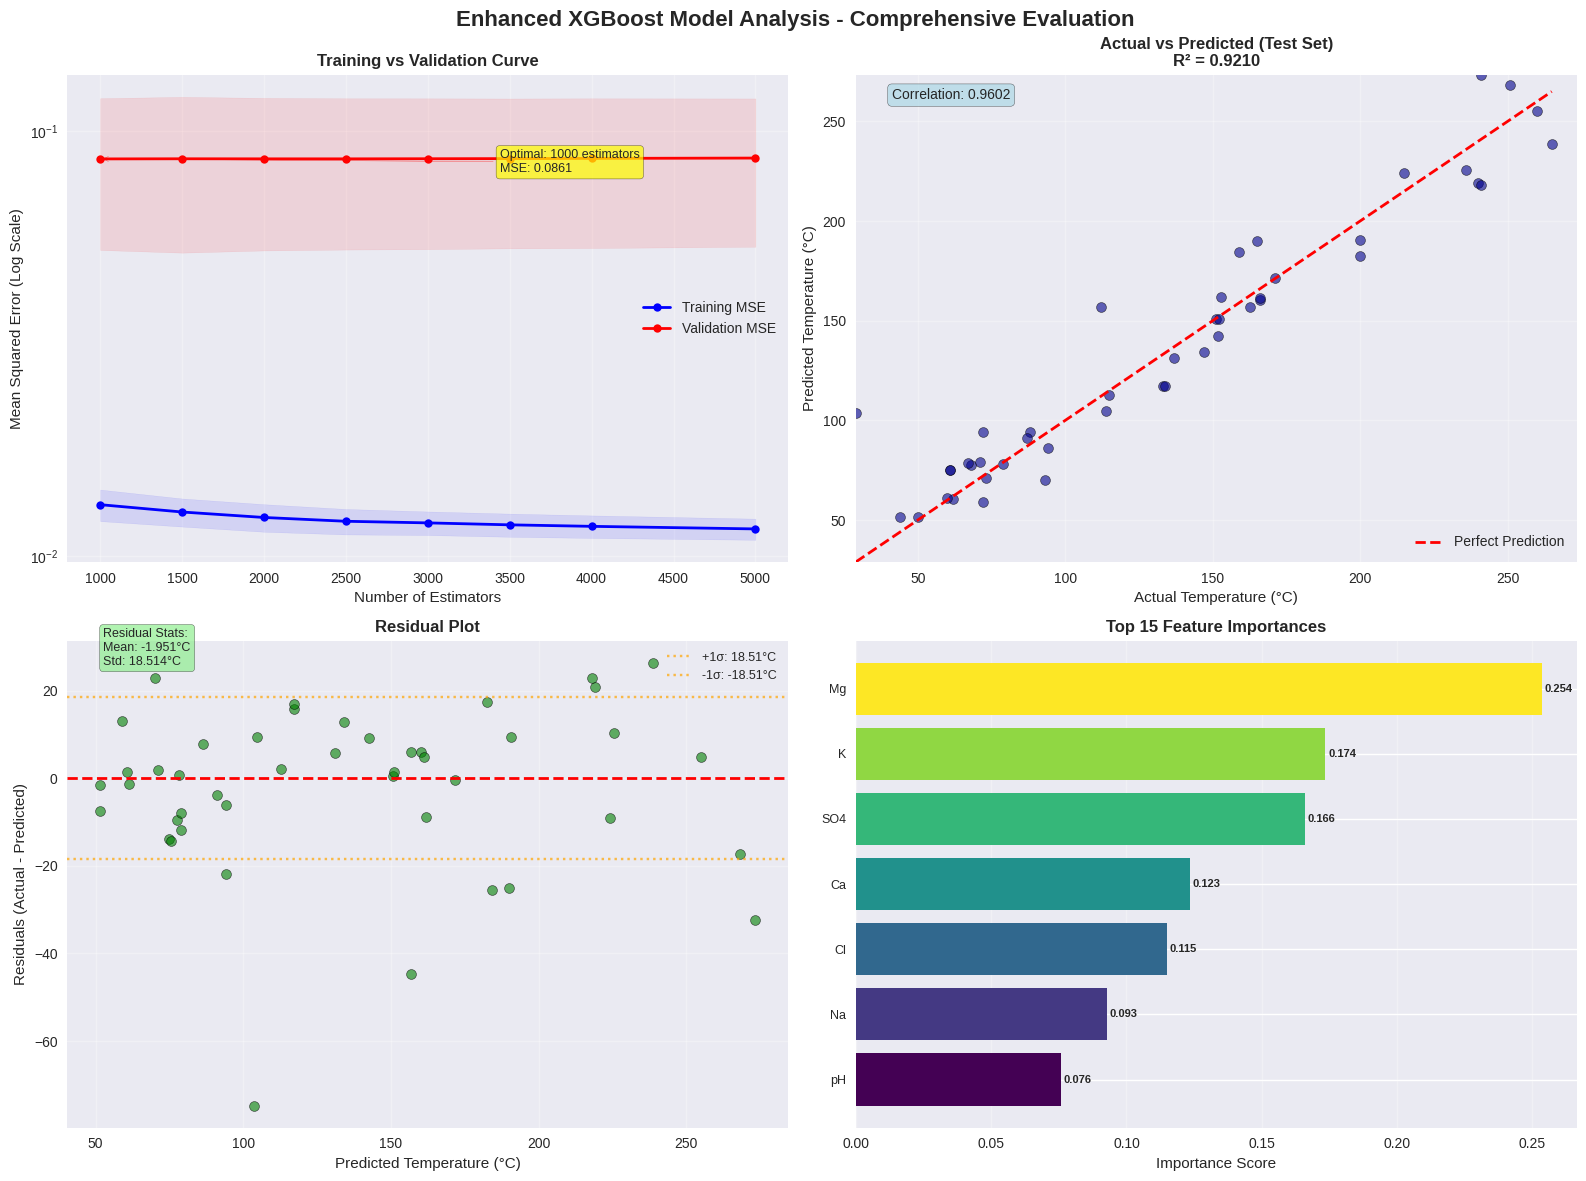

ENHANCED XGBOOST MODEL PERFORMANCE SUMMARY
Model Configuration:
  • Best CV Score (R²): 0.7338
  • Cross-validation folds: 10
  • Hyperparameter iterations: 50
  • Early stopping rounds: 100

Test Set Performance:
  • R² Score: 0.9210
  • Mean Absolute Error: 13.07°C
  • Root Mean Squared Error: 18.62°C
  • Mean Squared Log Error: 0.0490
  • Mean Relative Squared Error: 0.1638

Training Information:
  • Training Time: 17.99 seconds
  • Training samples: 254
  • Test samples: 45
  • Number of features: 7

Residual Analysis:
  • Residual mean: -1.9505°C
  • Residual std: 18.5138°C
  • 95% of residuals within: ±36.29°C

TOP 10 MOST IMPORTANT FEATURES:
--------------------------------------------------
 1. pH                        : 0.0757
 2. Na                        : 0.0927
 3. Cl                        : 0.1149
 4. Ca                        : 0.1234
 5. SO4                       : 0.1660
 6. K                         : 0.1735
 7. Mg                        : 0.2537


In [62]:
# Enhanced XGBoost Model Analysis with Comprehensive Visualizations

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import validation_curve

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Enhanced XGBoost Model Analysis - Comprehensive Evaluation', fontsize=16, fontweight='bold')

# 1. Training vs Validation Curve (using n_estimators as parameter)
print("Generating validation curves...")
n_estimators_range = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000]
train_scores, val_scores = validation_curve(
    xgb.XGBRegressor(
        **{k: v for k, v in xgb_best_params.items() if k != 'n_estimators'},
        random_state=42,
        verbosity=0
    ), 
    x_train_xg, y_train_log_xg,  # Using log-transformed target
    param_name='n_estimators', 
    param_range=n_estimators_range,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

axes[0, 0].plot(n_estimators_range, train_scores_mean, 'o-', color='blue', 
                label='Training MSE', linewidth=2, markersize=6)
axes[0, 0].fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axes[0, 0].plot(n_estimators_range, val_scores_mean, 'o-', color='red', 
                label='Validation MSE', linewidth=2, markersize=6)
axes[0, 0].fill_between(n_estimators_range, val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std, alpha=0.1, color='red')
axes[0, 0].set_xlabel('Number of Estimators', fontsize=11)
axes[0, 0].set_ylabel('Mean Squared Error (Log Scale)', fontsize=11)
axes[0, 0].set_title('Training vs Validation Curve', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Add annotations for optimal point
optimal_idx = np.argmin(val_scores_mean)
axes[0, 0].annotate(f'Optimal: {n_estimators_range[optimal_idx]} estimators\nMSE: {val_scores_mean[optimal_idx]:.4f}', 
                    xy=(n_estimators_range[optimal_idx], val_scores_mean[optimal_idx]),
                    xytext=(0.6, 0.8), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                    fontsize=9)

# 2. Actual vs Predicted (Test Set) - Back-transformed values
axes[0, 1].scatter(y_test_xg, y_pred_test_xg, alpha=0.6, color='darkblue', s=50, edgecolors='black', linewidth=0.5)
perfect_line = [y_test_xg.min(), y_test_xg.max()]
axes[0, 1].plot(perfect_line, perfect_line, 'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Temperature (°C)', fontsize=11)
axes[0, 1].set_ylabel('Predicted Temperature (°C)', fontsize=11)
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {r2_xgb:.4f}', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Add equal axes for better visualization
min_val = min(y_test_xg.min(), y_pred_test_xg.min())
max_val = max(y_test_xg.max(), y_pred_test_xg.max())
axes[0, 1].set_xlim(min_val, max_val)
axes[0, 1].set_ylim(min_val, max_val)

# Add correlation coefficient
correlation = np.corrcoef(y_test_xg, y_pred_test_xg)[0, 1]
axes[0, 1].text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
                transform=axes[0, 1].transAxes, fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

# 3. Residual Plot with enhanced analysis
residuals = y_test_xg - y_pred_test_xg
axes[1, 0].scatter(y_pred_test_xg, residuals, alpha=0.6, color='green', s=50, edgecolors='black', linewidth=0.5)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)', fontsize=11)
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
axes[1, 0].set_title('Residual Plot', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Add residual statistics
residual_std = np.std(residuals)
axes[1, 0].axhline(y=residual_std, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {residual_std:.2f}°C')
axes[1, 0].axhline(y=-residual_std, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {-residual_std:.2f}°C')
axes[1, 0].legend(fontsize=9)

# Add residual statistics text
axes[1, 0].text(0.05, 0.95, f'Residual Stats:\nMean: {np.mean(residuals):.3f}°C\nStd: {residual_std:.3f}°C', 
                transform=axes[1, 0].transAxes, fontsize=9,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

# 4. Feature Importance with enhanced visualization
feature_importance = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Top 15 most important features for better visibility
top_features = importance_df.tail(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars = axes[1, 1].barh(range(len(top_features)), top_features['importance'], color=colors)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 1].set_xlabel('Importance Score', fontsize=11)
axes[1, 1].set_title('Top 15 Feature Importances', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    axes[1, 1].text(importance + 0.001, i, f'{importance:.3f}', 
                    va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive model summary
print("="*80)
print("ENHANCED XGBOOST MODEL PERFORMANCE SUMMARY")
print("="*80)
print(f"Model Configuration:")
print(f"  • Best CV Score (R²): {random_search_xgb.best_score_:.4f}")
print(f"  • Cross-validation folds: 10")
print(f"  • Hyperparameter iterations: 50")
print(f"  • Early stopping rounds: 100")
print(f"\nTest Set Performance:")
print(f"  • R² Score: {r2_xgb:.4f}")
print(f"  • Mean Absolute Error: {mae_xgb:.2f}°C")
print(f"  • Root Mean Squared Error: {np.sqrt(mse_xgb):.2f}°C")
print(f"  • Mean Squared Log Error: {mslr_xgb:.4f}")
print(f"  • Mean Relative Squared Error: {mrse_xgb:.4f}")
print(f"\nTraining Information:")
print(f"  • Training Time: {training_time_xgb_rs:.2f} seconds")
print(f"  • Training samples: {len(x_train_xg)}")
print(f"  • Test samples: {len(x_test_xg)}")
print(f"  • Number of features: {x_train_xg.shape[1]}")
print(f"\nResidual Analysis:")
print(f"  • Residual mean: {np.mean(residuals):.4f}°C")
print(f"  • Residual std: {np.std(residuals):.4f}°C")
print(f"  • 95% of residuals within: ±{1.96*np.std(residuals):.2f}°C")
print("="*80)

# Display top 10 most important features
print("\nTOP 10 MOST IMPORTANT FEATURES:")
print("-" * 50)
for i, (idx, row) in enumerate(importance_df.tail(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<25} : {row['importance']:.4f}")
print("="*80)

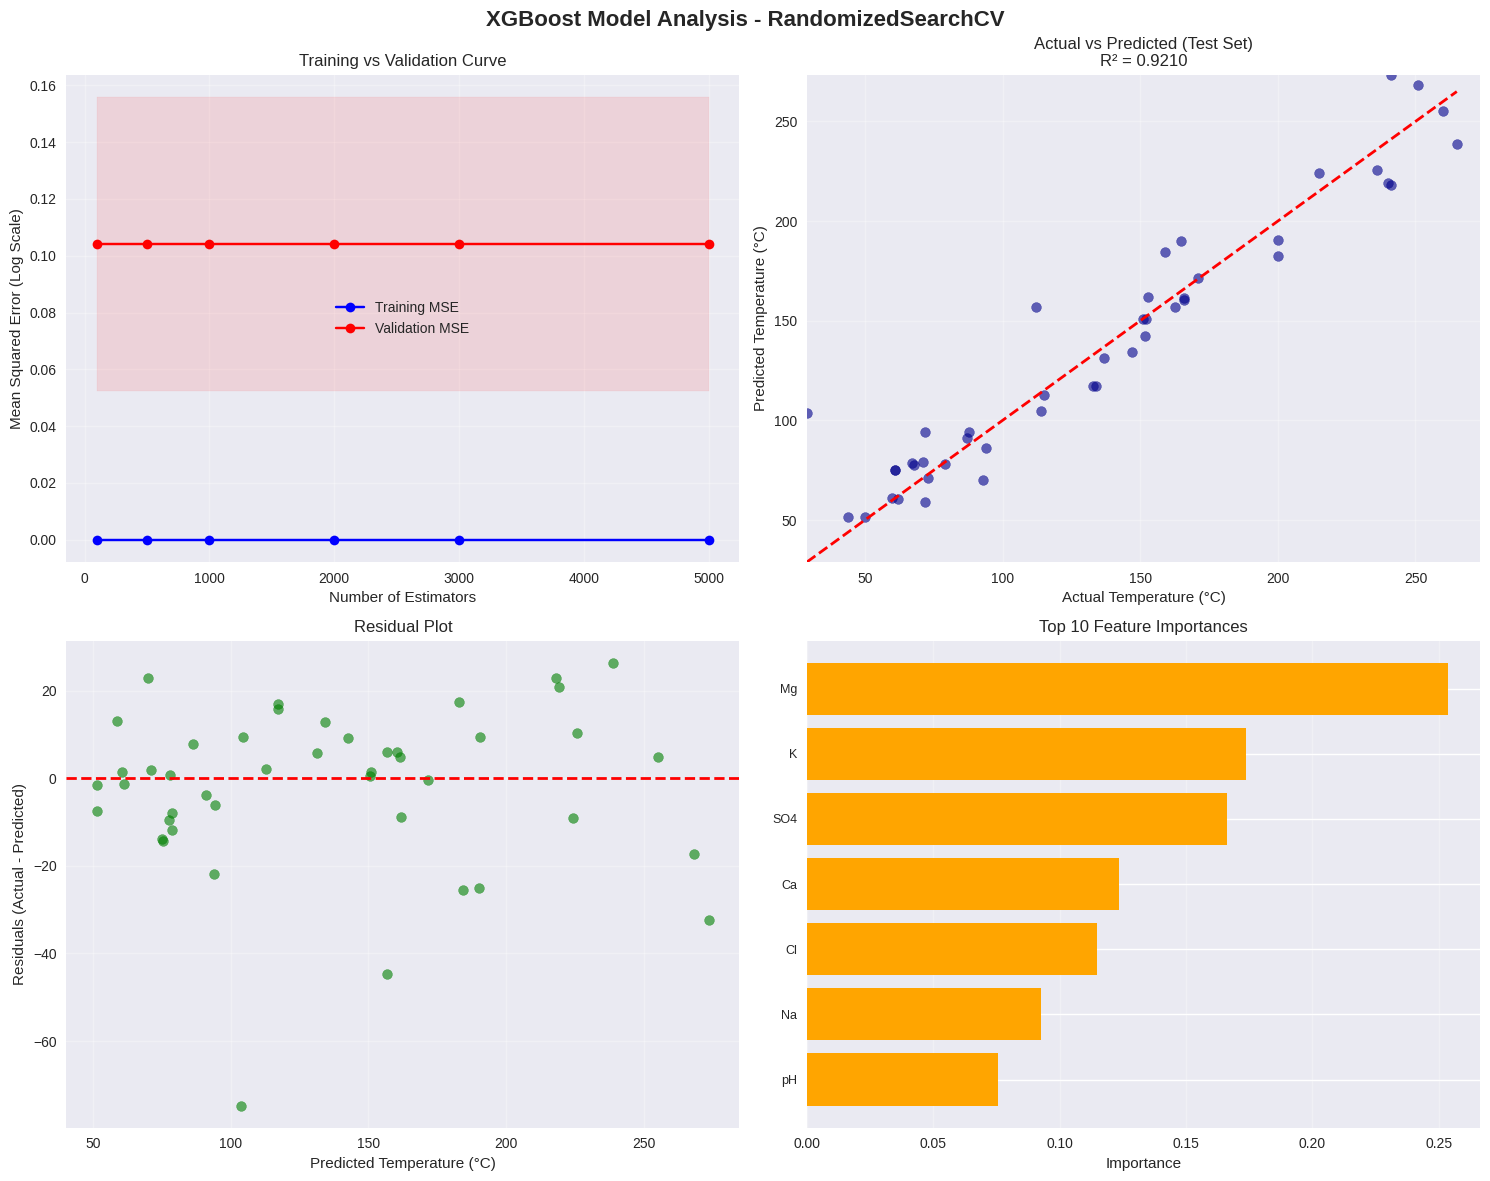


Model Performance Summary:
Best CV Score (R²): 0.7338
Test R²: 0.9210
Mean Absolute Error: 13.07°C
Root Mean Squared Error: 18.62°C
Training Time: 17.99 seconds


In [60]:

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('XGBoost Model Analysis - RandomizedSearchCV', fontsize=16, fontweight='bold')

# 1. Training vs Validation Curve (using n_estimators as parameter)
n_estimators_range = [100, 500, 1000, 2000, 3000, 5000]
train_scores, val_scores = validation_curve(
    xgb.XGBRegressor(random_state=50), 
    x_train_xg, y_train_log_xg,  # Note: using log-transformed target
    param_name='n_estimators', 
    param_range=n_estimators_range,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = -val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

axes[0, 0].plot(n_estimators_range, train_scores_mean, 'o-', color='blue', label='Training MSE')
axes[0, 0].fill_between(n_estimators_range, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='blue')
axes[0, 0].plot(n_estimators_range, val_scores_mean, 'o-', color='red', label='Validation MSE')
axes[0, 0].fill_between(n_estimators_range, val_scores_mean - val_scores_std,
                        val_scores_mean + val_scores_std, alpha=0.1, color='red')
axes[0, 0].set_xlabel('Number of Estimators')
axes[0, 0].set_ylabel('Mean Squared Error (Log Scale)')
axes[0, 0].set_title('Training vs Validation Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (Test Set) - Back-transformed values
axes[0, 1].scatter(y_test_xg, y_pred_test_xg, alpha=0.6, color='darkblue', s=50)
axes[0, 1].plot([y_test_xg.min(), y_test_xg.max()], [y_test_xg.min(), y_test_xg.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Temperature (°C)')
axes[0, 1].set_ylabel('Predicted Temperature (°C)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {r2_xgb:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# Add equal axes for better visualization
min_val = min(y_test_xg.min(), y_pred_test_xg.min())
max_val = max(y_test_xg.max(), y_pred_test_xg.max())
axes[0, 1].set_xlim(min_val, max_val)
axes[0, 1].set_ylim(min_val, max_val)

# 3. Residual Plot
residuals = y_test_xg - y_pred_test_xg
axes[1, 0].scatter(y_pred_test_xg, residuals, alpha=0.6, color='green', s=50)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Temperature (°C)')
axes[1, 0].set_ylabel('Residuals (Actual - Predicted)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Feature Importance
feature_importance = xgb_model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True)

# Top 10 most important features
top_features = importance_df.tail(10)
axes[1, 1].barh(range(len(top_features)), top_features['importance'], color='orange')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['feature'], fontsize=9)
axes[1, 1].set_xlabel('Importance')
axes[1, 1].set_title('Top 10 Feature Importances')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nModel Performance Summary:")
print(f"Best CV Score (R²): {random_search_xgb.best_score_:.4f}")
print(f"Test R²: {r2_xgb:.4f}")
print(f"Mean Absolute Error: {mae_xgb:.2f}°C")
print(f"Root Mean Squared Error: {np.sqrt(mse_xgb):.2f}°C")
print(f"Training Time: {training_time_xgb_rs:.2f} seconds")

In [24]:
### XGBoost with Optuna hyperparameter optimization

start_time_xg_op = time.time()

x_train_xg, x_test_xg, y_train_log_xg, y_test_log_xg = train_test_split(X, np.log(Y), test_size=0.15, random_state=50)

scaler = StandardScaler()
x_train_xg = scaler.fit_transform(x_train_xg)
x_test_xg = scaler.transform(x_test_xg)

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1, 10000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }
    
    model = xgb.XGBRegressor(**params, random_state=42)
    score = cross_val_score(model, x_train_xg, y_train_log_xg, 
                          cv=10, scoring='r2').mean()
    return -score

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=10)

print("="*100)
print(f"Best XGBoost parameters: \n{study_xgb.best_params}")
print("="*100)

#params_filename = 'xgb_optuna_best_params.json'
#with open(params_filename, 'w') as params_file:
#    json.dump(study_xgb.best_params, params_file)
#print(f'Best parameters saved to: {params_filename}')

best_xgb = xgb.XGBRegressor(**study_xgb.best_params, 
                            random_state=42,  
                            eval_metrics='rmse', 
                            early_stopping_rounds=1500) #, tree_method='gpu_hist', predictor='gpu_predictor',)  ## Use GPU for training)

best_xgb.fit(x_train_xg, 
             y_train_log_xg,
             verbose = True,
             eval_set = [(x_train_xg, y_train_log_xg), (x_test_xg, y_test_log_xg)]
             )

end_time_xg_op = time.time()
training_time_xg_op = end_time_xg_op - start_time_xg_op

#model_filename = 'xgb_optuna_model.json'
#best_xgb.save_model(model_filename)
#print(f'Model saved to: {model_filename}')

y_pred_log_test_xg = best_xgb.predict(x_test_xg)
y_pred_log_train_xg = best_xgb.predict(x_train_xg)

y_pred_test_xg = np.exp(y_pred_log_test_xg)
y_pred_train_xg = np.exp(y_pred_log_train_xg)
y_train_xg = np.exp(y_train_log_xg)
y_test_xg = np.exp(y_test_log_xg)

r2_xgb = r2_score(y_test_xg, y_pred_test_xg)
mse_xgb = mean_squared_error(y_test_xg, y_pred_test_xg)
mae_xgb = mean_absolute_error(y_test_xg, y_pred_test_xg)
msle_xgb = mean_squared_log_error(y_test_xg, y_pred_test_xg)
mrse_xgb = mean_relative_squared_error(y_test_xg, y_pred_test_xg)

xgb_eval_metrics = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'XGBoost_Op': [r2_xgb, mse_xgb, mae_xgb, msle_xgb, mrse_xgb, training_time_xg_op]
}

xgb_df_metrics = pd.DataFrame(xgb_eval_metrics)
xgb_df_metrics.to_csv('metrics/metrics_xgb_op.csv', index=False)

print(tabulate(xgb_df_metrics.round(4), headers='keys', tablefmt='pretty', showindex=False))

#Plot optimization history
#optuna.visualization.plot_optimization_history(study_xgb)
#plt.show()

[I 2025-09-04 18:12:08,556] A new study created in memory with name: no-name-44e4ad83-fa45-4f8c-9d6d-a8f01a94ac9d
[I 2025-09-04 18:12:19,412] Trial 0 finished with value: -0.733460425849289 and parameters: {'max_depth': 69, 'learning_rate': 0.002356059013877413, 'n_estimators': 2612, 'min_child_weight': 5, 'gamma': 0.06830334954821318, 'subsample': 0.4301062133109709, 'colsample_bytree': 0.644675919741867, 'reg_alpha': 0.0003448505927250258, 'reg_lambda': 1.4697629324658703e-06}. Best is trial 0 with value: -0.733460425849289.
[I 2025-09-04 18:12:48,513] Trial 1 finished with value: -0.6856177693878504 and parameters: {'max_depth': 68, 'learning_rate': 0.0007731775211843004, 'n_estimators': 7647, 'min_child_weight': 17, 'gamma': 3.117516638813265e-07, 'subsample': 0.5963281570764912, 'colsample_bytree': 0.71954118156552, 'reg_alpha': 0.3919490666745151, 'reg_lambda': 0.282019431956625}. Best is trial 0 with value: -0.733460425849289.
[I 2025-09-04 18:12:58,984] Trial 2 finished with va

KeyboardInterrupt: 

The 'scoring' parameter of cross_val_score must be a str among {'roc_auc_ovo', 'top_k_accuracy', 'f1_samples', 'f1', 'matthews_corrcoef', 'max_error', 'neg_mean_squared_log_error', 'recall_micro', 'roc_auc_ovr_weighted', 'positive_likelihood_ratio', 'explained_variance', 'neg_negative_likelihood_ratio', 'recall_samples', 'jaccard_weighted', 'normalized_mutual_info_score', 'neg_mean_gamma_deviance', 'neg_median_absolute_error', 'roc_auc_ovr', 'neg_mean_squared_error', 'neg_brier_score', 'rand_score', 'balanced_accuracy', 'jaccard_micro', 'accuracy', 'jaccard_samples', 'adjusted_mutual_info_score', 'neg_mean_absolute_error', 'roc_auc_ovo_weighted', 'average_precision', 'r2', 'f1_macro', 'precision', 'precision_micro', 'precision_macro', 'recall', 'recall_macro', 'homogeneity_score', 'adjusted_rand_score', 'neg_log_loss', 'roc_auc', 'neg_mean_absolute_percentage_error', 'v_measure_score', 'recall_weighted', 'fowlkes_mallows_score', 'mutual_info_score', 'neg_root_mean_squared_error', 'completeness_score', 'neg_root_mean_squared_log_error', 'precision_weighted', 'd2_absolute_error_score', 'f1_weighted', 'neg_mean_poisson_deviance', 'jaccard', 'jaccard_macro', 'precision_samples', 'f1_micro'}, a callable or None. Got {'r2': make_scorer(r2_score, response_method='predict'), 'neg_mse': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'), 'neg_mae': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict')} instead.

In [26]:
### TabPFN for Temperature Prediction

from tabpfn import TabPFNRegressor

start_time_tabpfn = time.time()

x_train_tab, x_test_tab, y_train_log_tab, y_test_log_tab = train_test_split(X, np.log(Y), test_size=0.15, random_state=50)

scaler = StandardScaler()
x_train_tab = scaler.fit_transform(x_train_tab)
x_test_tab = scaler.transform(x_test_tab)

tabpfn_regressor = TabPFNRegressor(
    device='cpu',  # Use 'cuda' if you have a GPU
)

tabpfn_regressor.fit(x_train_tab, y_train_log_tab)

y_pred_log_test = tabpfn_regressor.predict(x_test_tab)
y_pred_log_train = tabpfn_regressor.predict(x_train_tab)

y_pred_test = np.exp(y_pred_log_test)
y_pred_train = np.exp(y_pred_log_train)
y_train = np.exp(y_train_log_tab)
y_test = np.exp(y_test_log_tab)

end_time_tabpfn = time.time()
training_time_tabpfn = end_time_tabpfn - start_time_tabpfn

def mean_relative_squared_error(Y_true, Y_pred):
    return np.mean(((Y_true - Y_pred) / Y_true) ** 2)

r2_tabpfn = r2_score(y_test, y_pred_test)
mse_tabpfn = mean_squared_error(y_test, y_pred_test)
mae_tabpfn = mean_absolute_error(y_test, y_pred_test)
msle_tabpfn = mean_squared_log_error(y_test, y_pred_test)
mrse_tabpfn = mean_relative_squared_error(y_test, y_pred_test)

tabpfn_eval_metrics = {
    'Eval_metrics': ['R2 Score', 'MSE', 'MAE', 'MSLE', 'MRSE', 'Training time'],
    'TabPFN Model': [r2_tabpfn, mse_tabpfn, mae_tabpfn, msle_tabpfn, mrse_tabpfn, training_time_tabpfn]
}

tabpfn_df_metrics = pd.DataFrame(tabpfn_eval_metrics)
tabpfn_df_metrics.to_csv('metrics/metrics_tabpfn.csv', index=False)

print(tabulate(tabpfn_df_metrics.round(4), headers='keys', tablefmt='pretty', showindex=False))


/home/chris/venv/cdd/lib/python3.12/site-packages/tabpfn/regressor.py:494: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(


+---------------+--------------+
| Eval_metrics  | TabPFN Model |
+---------------+--------------+
|   R2 Score    |    0.9265    |
|      MSE      |   322.5407   |
|      MAE      |    10.799    |
|     MSLE      |    0.0489    |
|     MRSE      |    0.1893    |
| Training time |   11.8212    |
+---------------+--------------+
